Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):

01-06 SOUID: Source identifier

08-15 DATE : Date YYYYMMDD

17-21 TG   : mean temperature in 0.1 &#176;C

23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).

Blended and updated with sources: 111448 127488 128124 

See file sources.txt and stations.txt for more info.

In [402]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# statistics stack
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

In [403]:
FILE_PATH = "/Users/elizavetabugaeva/Documents/Spiced/weekly_milestones/week_07/ECA_blended_custom/TG_STAID002759.txt"

df = pd.read_csv(
FILE_PATH,
#start from row 20
skiprows=19,
skipinitialspace = True,
#column #1 is dates in our original data 
parse_dates = [1]
)

In [404]:
df

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0
...,...,...,...,...
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0


In [405]:
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0


In [406]:
df.tail()

,SOUID,DATE,TG,Q_TG
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0
53780,111448,2023-03-31,108,0


In [407]:
df_missing = df[df['Q_TG']==9]

In [408]:
df_missing['DATE'].min()

Timestamp('1945-04-25 00:00:00')

In [409]:
df_missing['DATE'].max()

Timestamp('1945-11-05 00:00:00')

In [410]:
#number of days with missing vallues
missing_days= (df_missing['DATE'].max() - df_missing['DATE'].min()).days +1
missing_days

195

In [411]:
#check is all missing days actually miss values
missing_days == df_missing.shape[0]

True

## Data Preprocessing

Missing days need to be inputed for the model to work

In [412]:
from dateutil.relativedelta import relativedelta

In [413]:
# reference years are all years 5 years before and  5 years after
reference_years = list(range(-5,6))
reference_years.remove(0)
# function for clean temperature values
def clean_temp(df,x):
    """
    returns a temperaure column in celcius with missing values imputed;
    imputation is done with the average of the temperautes on the same
    day over all the reference years; division by 10 for celcius value
    """
    # if missing value occurs
    if x['Q_TG']==9:
        # list reference dates
        reference_dates = [x['DATE']+relativedelta(years=y) for y in reference_years]
        # mean temperatue over the references dates
        temp_value = df[df['DATE'].isin(reference_dates)]['TG'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['TG']/10

In [414]:
# create clean temperatutre column
df['TEMP'] = df.apply(
    lambda x: clean_temp(df,x),
    axis=1
)

In [415]:
#check that values are filled out
df[df['DATE']=='1945-07-25']

,SOUID,DATE,TG,Q_TG,TEMP
25407,127488,1945-07-25,-9999,9,20.6


In [416]:
df

,SOUID,DATE,TG,Q_TG,TEMP
0,127488,1876-01-01,22,0,2.2
1,127488,1876-01-02,25,0,2.5
2,127488,1876-01-03,3,0,0.3
3,127488,1876-01-04,-58,0,-5.8
4,127488,1876-01-05,-98,0,-9.8
...,...,...,...,...,...
53776,111448,2023-03-27,34,0,3.4
53777,111448,2023-03-28,35,0,3.5
53778,111448,2023-03-29,66,0,6.6
53779,111448,2023-03-30,117,0,11.7


### Train-test split

In [417]:
df.columns = df.columns.str.lower()
clean_df = df.set_index('date')[['temp']]

In [418]:
clean_df.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [419]:
df.shape

(53781, 5)

In [420]:
train = clean_df[:'2022-12-31']
train.shape

(53691, 1)

In [421]:
test = clean_df['2023-01-01':]

In [422]:
test.shape

(90, 1)

In [423]:
train.to_csv('temp_train.csv')
test.to_csv('temp_test.csv')

### Split data to noise and denoised

In [424]:
#import savitzky-golay filter
from scipy.signal import savgol_filter

In [425]:
train['denoised']=savgol_filter(np.array(train['temp']),99,3, mode='nearest')

In [426]:
train['denoised']

date
1876-01-01   -0.659391
1876-01-02   -0.772946
1876-01-03   -0.858296
1876-01-04   -1.025494
1876-01-05   -1.151521
                ...   
2022-12-27    6.827954
2022-12-28    7.212065
2022-12-29    7.611574
2022-12-30    8.021626
2022-12-31    8.411407
Name: denoised, Length: 53691, dtype: float64

<AxesSubplot:xlabel='date'>

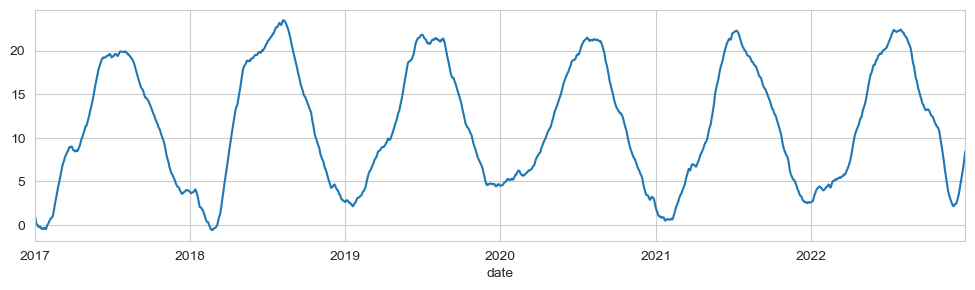

In [427]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train['denoised']['2017-01-01':'2022-12-31'].plot()

In [428]:
test['denoised']=savgol_filter(np.array(test['temp']),99,3, mode='nearest')

<AxesSubplot:xlabel='date'>

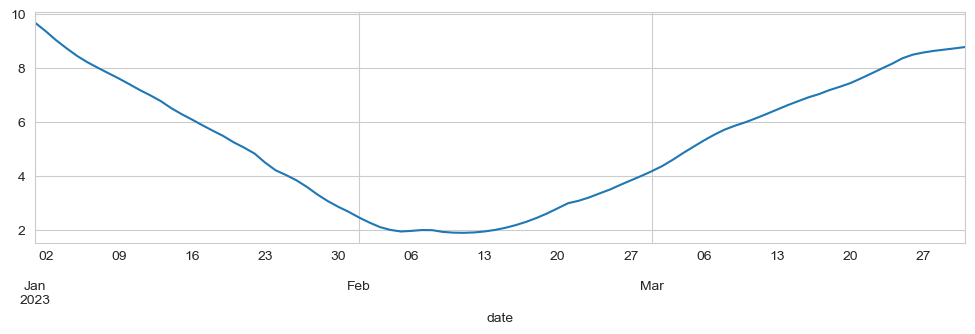

In [429]:
mpl.rc('figure',figsize=(12,3),dpi=100)
test['denoised'].plot()

### Noise

In [430]:
train['noise'] = train['temp'] - train['denoised']

In [431]:
test['noise'] = test['temp'] - test['denoised']

<AxesSubplot:xlabel='date'>

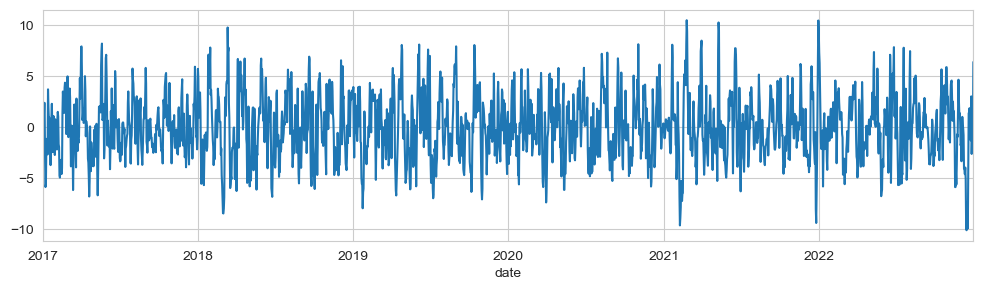

In [432]:
train['noise']['2017-01-01':'2022-12-31'].plot()

## Working with denoised data only

In [433]:
#calculate qcd
def qcd_variance(series,window=100): #12 because we work with months
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")
    
    #this function tells you if the series varies a lot or not

In [434]:
qcd_variance(train['denoised'])

quartile coefficient of dispersion: 0.617189


quartile coefficient of dispersion is close to 1 and tranformationd do not help -> will be using multiplicative model in the end 

## Baseline Model

### Extracting Trend

In [435]:
train['timestep']= list(range(0,train.shape[0]))

In [436]:
X_trend = train[['timestep']]
y_trend = train['denoised']

In [437]:
trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [438]:
trend_model.fit(X_trend,y_trend)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

### Prediction of the trend for denoised data

In [439]:
train['trend_denoised'] = trend_model.predict(X_trend)

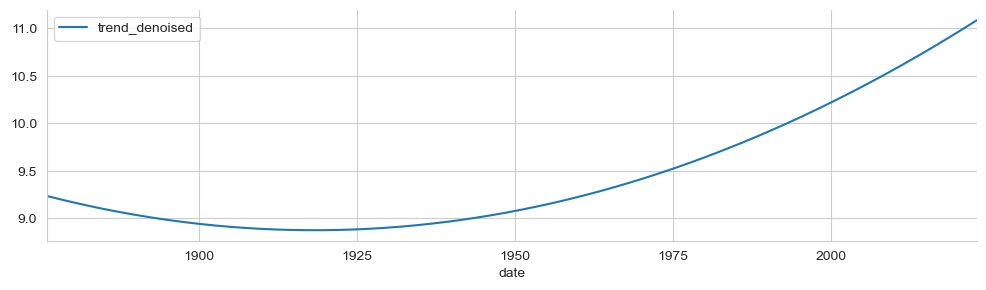

In [440]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['trend_denoised'].plot(legend=True)
sns.despine()

### Removing trend 

In [441]:
#denoised detrended data
train['detrended_d'] = train['denoised'] - train['trend_denoised']

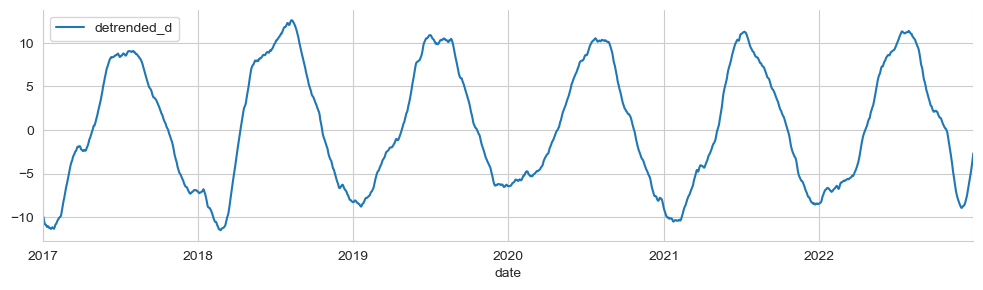

In [442]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended_d']['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

<AxesSubplot:xlabel='date'>

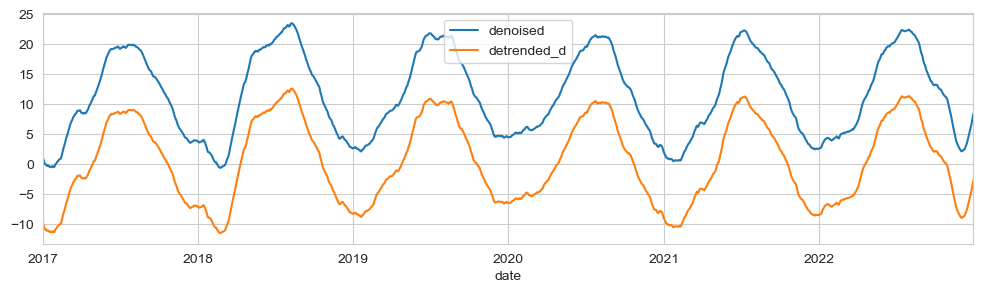

In [443]:
train[['denoised','detrended_d']]['2017-01-01':'2022-12-31'].plot(legend=True)

### Extracting seasonality 

In [444]:
f=1/365.24

In [445]:
train['season_cos'] = np.cos(2*np.pi*f*train['timestep'])
train['season_sin']= np.sin(2*np.pi*f*train['timestep'])

<AxesSubplot:xlabel='date'>

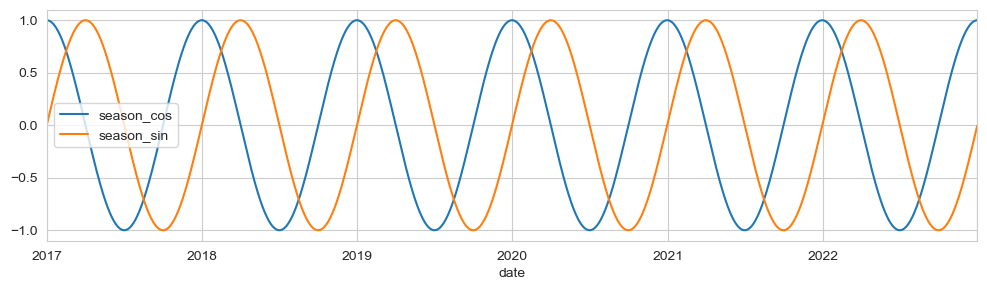

In [446]:
train[['season_cos','season_sin']]['2017-01-01':'2022-12-31'].plot(legend=True)

### Seasonality model

In [447]:
X_train_season = train[['season_cos','season_sin']]
y_train_season = train['detrended_d']

In [448]:
seasonality_model =LinearRegression()

In [449]:
seasonality_model.fit(X_train_season, y_train_season)

LinearRegression()

In [450]:
train['seasonality_sincos'] = seasonality_model.predict(X_train_season)

In [451]:
train['seasonality_sincos']

date
1876-01-01   -9.336733
1876-01-02   -9.381615
1876-01-03   -9.423721
1876-01-04   -9.463038
1876-01-05   -9.499555
                ...   
2022-12-27   -9.113596
2022-12-28   -9.170201
2022-12-29   -9.224092
2022-12-30   -9.275254
2022-12-31   -9.323670
Name: seasonality_sincos, Length: 53691, dtype: float64

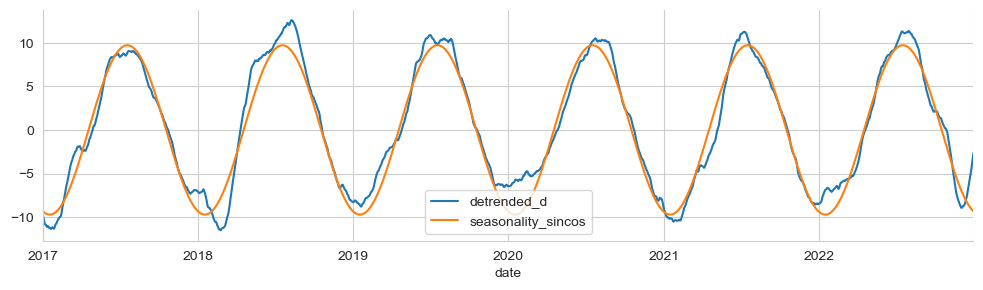

In [452]:
#plot seasonality prediction vs detranded data
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended_d','seasonality_sincos']]['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

One-hot encoder method

## Extracting seasonality woth dayofyear norlmalisation

In [460]:
# Convert the index to a pandas DatetimeIndex
clean_df.index = pd.to_datetime(clean_df.index)

# Extract day of the year from the index and normalize it to range from 0 to 1
day_of_year = clean_df.index.dayofyear
day_of_year_normalized = (day_of_year - 1) / 365.24

# Create a seasonality column with values ranging from 0 to 1
clean_df['seasonality_norm'] = day_of_year_normalized

In [461]:
X_season = clean_df.loc[:'2022-12-31', ['seasonality_norm']]
y_season = train['detrended_d']

In [462]:
X_season

,seasonality_norm
date,
1876-01-01,0.000000
1876-01-02,0.002738
1876-01-03,0.005476
1876-01-04,0.008214
1876-01-05,0.010952
...,...
2022-12-27,0.985653
2022-12-28,0.988391
2022-12-29,0.991129


In [463]:
seasonality_model_norm = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [464]:
seasonality_model_norm.fit(X_season, y_season)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [465]:
train['seasonality_norm'] = seasonality_model_norm.predict(X_season)

In [466]:
train['seasonality_norm']

date
1876-01-01   -9.067679
1876-01-02   -9.103861
1876-01-03   -9.141828
1876-01-04   -9.176523
1876-01-05   -9.206905
                ...   
2022-12-27   -8.820279
2022-12-28   -8.848868
2022-12-29   -8.883836
2022-12-30   -8.922330
2022-12-31   -8.965668
Name: seasonality_norm, Length: 53691, dtype: float64

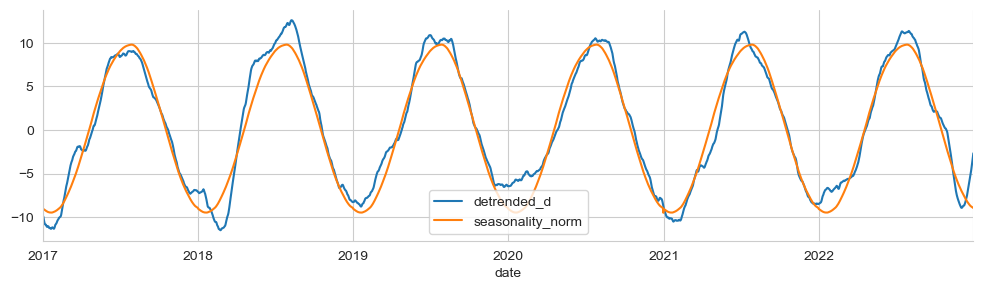

In [467]:
#plot seasonality prediction vs detranded data
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended_d','seasonality_norm']]['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

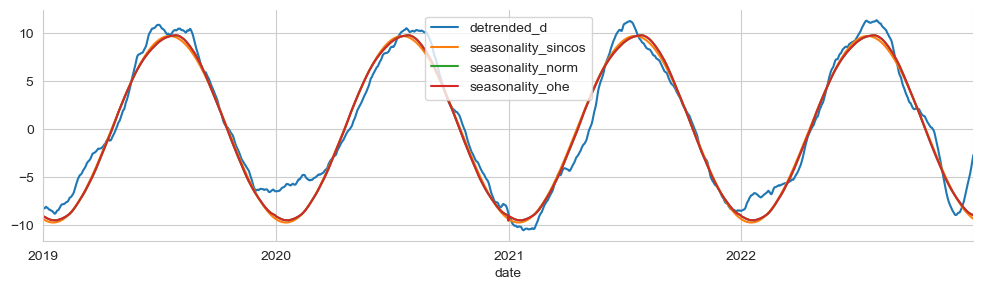

In [468]:
#plot seasonality prediction vs detranded data
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended_d', 'seasonality_sincos', 'seasonality_norm','seasonality_ohe']]['2019-01-01':'2022-12-31'].plot()
sns.despine()

## Baseline Model

In [469]:
train['baseline_ohe'] = train['trend_denoised'] + train['seasonality_ohe']

In [471]:
r2_baseline_ohe= round(r2_score(train['denoised'],train['baseline_ohe']),6)
print(f"r2_score: {r2_baseline_ohe}")

r2_score: 0.941026


In [472]:
train['baseline_sincos'] = train['trend_denoised'] + train['seasonality_sincos']

In [ ]:
r2_baseline_sincos= round(r2_score(train['denoised'],train['baseline_sincos']),6)
print(f"r2_score: {r2_baseline_sincos}")

r2_score: 0.940332


In [473]:
train['baseline_norm'] = train['trend_denoised'] + train['seasonality_norm']

In [474]:
r2_baseline_norm= round(r2_score(train['denoised'],train['baseline_norm']),6)
print(f"r2_score: {r2_baseline_norm}")

r2_score: 0.941026


In [475]:
train[['seasonality_norm','seasonality_ohe']]

,seasonality_norm,seasonality_ohe
date,,
1876-01-01,-9.067679,-9.067679
1876-01-02,-9.103861,-9.103861
1876-01-03,-9.141828,-9.141828
1876-01-04,-9.176523,-9.176523
1876-01-05,-9.206905,-9.206905
...,...,...
2022-12-27,-8.820279,-8.820279
2022-12-28,-8.848868,-8.848868
2022-12-29,-8.883836,-8.883836


## Model Remainder

In [ ]:
train['remainder'] = train['denoised'] - train['baseline_denoised']

In [ ]:
train['remainder']['2017-01-01':'2022-12-31'].plot(legend=True)

In [ ]:
qcd_variance(train['remainder'])

after inspecting remainder qsd qcd_variance use log transformation to stabilise mean

In [ ]:
train['remainder_trans'] = np.log1p(train['remainder'])

In [ ]:
qcd_variance(train['remainder_trans'])

In [ ]:
arima_model = pm.auto_arima(
    train['remainder'],
    start_p=0, 
    max_p=5,
    seasonality = False,
    stationarity = False,
    d=None,
    trace = True,
    n_jobs=-1
)

In [ ]:
#predictions from arima
#add all up 
#check the score 
#move to test 

In [ ]:
arima_model.fit(train['remainder'])

In [ ]:
train['remainder_arima'] = arima_model.predict_in_sample()

## Complete the model

In [ ]:
train['full_pred'] = train['remainder_arima'] + train['baseline_denoised']

In [ ]:
r2_fullpred = round(r2_score(train['denoised'],train['full_pred']),6)
print(f"r2_score: {r2_fullpred}")

### Use ARIMA on the noise

In [ ]:
arima_noise = pm.auto_arima(
    train['noise'],
    max_p=5,
    seasonality = False,
    stationarity = True,
    d=None,
    trace = True,
    n_jobs=-1
)

In [ ]:
train['noise_pred'] = arima_noise.predict_in_sample()

In [ ]:
train['noise_pred']

In [ ]:
r2_noise = round(r2_score(train['noise'],train['noise_pred']),6)
print(f"r2_score: {r2_noise}")

In [ ]:
qcd_variance(train['noise'])

In [ ]:
train['noise']['2017-01-01':'2022-12-31'].plot()

In [ ]:
train['full_pred_noisy']= train['noise_pred'] + train['full_pred']

In [ ]:
r2_rull_train = round(r2_score(train['temp'],train['full_pred_noisy']),6)
print(f"r2_score: {r2_rull_train}")

Adding noise predictions made r2 score worse -> maybe do more pre-work with it first

## Test Data

### Baseline Model

In [ ]:
test['timestep'] = list(range(train.shape[0], train.shape[0] + test.shape[0]))

In [ ]:
#checking if timestep is ordered correctly
train['timestep']

In [ ]:
test['timestep']

In [ ]:
X_trend_t = test[['timestep']]

In [ ]:
test['trend_denoised'] = trend_model.predict(X_trend_t)

In [ ]:
#Plot trend point vs output
mpl.rc('figure',figsize=(12,3),dpi=100)

test[['trend_denoised','denoised']].plot(legend=True)
sns.despine()

In [ ]:
test['detrended_d'] = test['denoised'] - test['trend_denoised']

In [ ]:
test['season_cos'] = np.cos(np.sin(2*np.pi*f*test['timestep']))
test['season_sin']= np.sin(np.sin(2*np.pi*f*test['timestep']))

In [ ]:
X_season_t = test[['season_cos','season_sin']]
y_season_t = test['detrended_d']

In [ ]:
X_season_t

In [ ]:
test['seasonality'] = seasonality_model.predict(X_season_t)

In [ ]:
mpl.rc('figure',figsize=(12,3),dpi=100)

test[['baseline_denoised','denoised']].plot(legend=True)
sns.despine()

In [ ]:
#baseline model
test['baseline_denoised'] = test['trend_denoised'] + test['seasonality']

In [ ]:
#Plot baseline point vs output
mpl.rc('figure',figsize=(12,3),dpi=100)

test[['baseline_denoised','denoised']].plot(legend=True)
sns.despine()

### Remainder

In [ ]:
test['remainder'] = test['denoised'] - test['baseline_denoised']

In [ ]:
test['arima_denoised'] = arima_model.predict(test.shape[0], return_conf_int=True)[0]

In [ ]:
test['arima_denoised']

In [ ]:
test['full_pred_denoised'] = test['arima_denoised'] + test['baseline_denoised']

In [ ]:
r2_denoised_test = round(r2_score(test['temp'],test['full_pred_denoised']),6)
print(f"r2_score: {r2_denoised_test}")

In [ ]:
test[['temp','full_pred_denoised']]

In [ ]:
mpl.rc('figure',figsize=(12,3),dpi=100)

test[['temp','full_pred_denoised']].plot(legend=True)
sns.despine()

Add noise

In [ ]:
test['full_pred_noisy'] = arima_noise.predict(test.shape[0], return_conf_int=True)[0]

In [ ]:
mpl.rc('figure',figsize=(12,3),dpi=100)

test[['temp','full_pred_noisy']].plot(legend=True)
sns.despine()

In [ ]:
r2_test = round(r2_score(test['temp'],test['baseline_denoised']),6)
print(f"r2_score: {r2_test}")